# MoleGen - a generative Machine Learning model for chemical molecules

In this post, I will be replicating the model and results from the following 2019 paper: [A Two-Step Graph Convolutional Decoder for Molecule Generation](https://arxiv.org/pdf/1906.03412).

## Prereqs

In [ ]:
%%capture
%pip install torch_geometric torch pandas matplotlib rdkit scikit-learn

## Imports

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from tqdm.auto import tqdm
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils import dense_to_sparse
from rdkit.Chem.rdchem import BondType
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from collections import defaultdict
from sklearn.manifold import TSNE

tqdm.pandas() # enable progress bars in pandas

## Preparation - paper read

We start by reading the paper. As a first pass, we can make the following comments:

- The authors used the ZINC dataset
- The very first input to the model is a canonical SMILES representation -> this needs to be converted into a graph ([see page 13/26 of this paper](https://arxiv.org/pdf/1610.02415) for more info on the encoding process). We will also need to extract the position information
- We use a graph convolutional network (GCN) encoder to aggregate information from neighbors for each node and edge
- We then have a simple MLP to convert the output to a matrix and create an output such that we have a one-hot vector essentially of how many atoms of each atom type, and we choose the index that has the maximum
- Then we need to decode this and so we start with a fully connected graph (I'm assuming the edge types are randomized).


As a first step, we want to look at our data and build the encoder.

## Dataset exploration

Next, we will load the ZINC dataset and explore it. We will only load a subset first.

Note that we can't use the builtin ZINC dataset from PyTorch because we lose the SMILES representation and we don't know the mapping from integer encoding to the atom and edge type. I think this is [somewhere explained here though](https://pubs.acs.org/doi/full/10.1021/acs.jcim.5b00559) or [here](https://zinc15.docking.org/catalogs/home/). However, we don't need the entire ZINC. Only a small subset.

We will use the [ZINC-250k dataset](https://www.kaggle.com/datasets/basu369victor/zinc250k) which is available on Kaggle. Note for debugging we will only load 1000 molecules.

We will use [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html) to convert these SMILES strings into canonical strings and to extract the connectivity for PyTorch geometric. But first, we have to load in our data. We will use Pandas dataframes for this. Note that most of these libraries are already pre-installed on Google colab

In [13]:
ZINC_URL = "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv"
N_SAMPLES = 1000

df = pd.read_csv(ZINC_URL, nrows=N_SAMPLES)

print(df.shape)
df.head()

(1000, 4)


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


Let's see how many unique SMILES we have. Eventually we will extract the canonical SMILES to filter out identical molecules. To do that, we apply a function to the DF to get the molecular representation, and then convert it back to SMILES. I'm borrowing this 'standardization' which was shown by Pat Walters in his tutorials. I don't know if much is needed other than the canonicalization.

In [17]:
df['mol'] = df.smiles.progress_apply(Chem.MolFromSmiles)
df['canonical_smiles'] = df.mol.progress_apply(Chem.MolToSmiles)
print("Unique non-canonical smiles:", len(df.smiles.unique()))
print("Unique canonical smiles:", len(df.canonical_smiles.unique()))
# strip needed because a \n is added to the 'smiles' field due to dataset
print("Number of changes:", len(df[(df.smiles.str.strip() != df.canonical_smiles)]))

100%|██████████| 1000/1000 [00:00<00:00, 8475.48it/s]

Unique non-canonical smiles: 1000
Unique canonical smiles: 1000
Number of changes: 16


Well looks like all our strings are already canonical except for a few. We can likely skip this step for the rest of the dataset.

Next, we can visualize a few of the molecules just to get a sense of their structure.

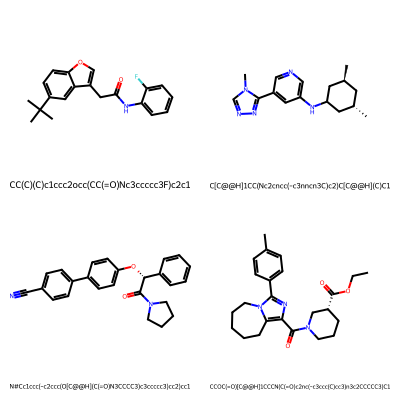

In [18]:
Draw.MolsToGridImage(df.mol[0:4],molsPerRow=2,legends=list(df.canonical_smiles[0:4]))

We need to create a mapping from index to atom type, and atom type back to index so that we can decode the atoms. Think of it like a tokenizer encoder/decoder. This will be a dictionary. Same thing for the edges.

We will scan through our dataset and create our vocabulary which maps atom symbol to indice, and vice versa

In [20]:
a2t = dict() # atom to token
t2a = dict() # token to atom
e2t = dict() # edge to token
t2e = dict() # token to edge

# for a given molecule, what is the maximum amount of atoms which are present 
# used to set the output matrix size when doing softmax
max_atoms = float('-inf') 

# RDKit has a lot of options here, but we will constrain to these 4
# and maybe make a note of which molecules have bonds we wouldn't expect
# https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Bond.GetIdx
# note that we are treating aromatic as a "double" bond
BOND_TYPES = ["NONE", "SINGLE", "DOUBLE", "TRIPLE"]
for idx, bond_type in enumerate(BOND_TYPES):
    e2t[bond_type] = idx
    t2e[idx] = bond_type

bond_types_in_dataset = set()

for mol in list(df.mol):
    max_atoms = max(max_atoms, mol.GetNumAtoms())
    
    for atom in mol.GetAtoms():
        
        symbol = atom.GetSymbol()
        
        if symbol not in a2t:
            t = len(a2t)
            a2t[atom.GetSymbol()] = t
            t2a[t] = atom.GetSymbol()

        for bond in atom.GetBonds():
            bond_types_in_dataset.add(bond.GetBondType().name)

print("Atom to token:", a2t)
print("Token to atom:", t2a)
print("Edge to token:", e2t)
print("Token to edge:", t2e)
print("Bond types in dataset:", bond_types_in_dataset)
print("Max number of atoms in any given molecule:", max_atoms)

Atom to token: {'C': 0, 'O': 1, 'N': 2, 'F': 3, 'S': 4, 'Cl': 5, 'Br': 6, 'I': 7}
Token to atom: {0: 'C', 1: 'O', 2: 'N', 3: 'F', 4: 'S', 5: 'Cl', 6: 'Br', 7: 'I'}
Edge to token: {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
Token to edge: {0: 'NONE', 1: 'SINGLE', 2: 'DOUBLE', 3: 'TRIPLE'}
Bond types in dataset: {'SINGLE', 'AROMATIC', 'DOUBLE', 'TRIPLE'}
Max number of atoms in any given molecule: 37


Next, we'll define some data parsing functions which will be applied to each molecule.

In [ ]:
# TODO -> make these utility functions that we download from my repository,
# or really simplify these to be much smaller (we only really need to do GetSymbol and GetIdx)
# for atom_info() function, e.g.

def atom_info(mol, verbose=False):
    """Extract RDKit info from mol object's atoms
    
    Iterate through the atoms in `mol` and return information such as
    the atom symbol, atomic number, bond degree, etc.
    """
    atoms = []

    if verbose:
        print("ATOM_INFO:")
        print("SYMBOL INDEX NUMBER DEGREE")
        
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        idx = atom.GetIdx()
        num = atom.GetAtomicNum()
        deg = atom.GetDegree()

        atoms.append((symbol, idx, num, deg))

        if verbose:
            print(*atoms[-1])

    if verbose:
        print()

    return atoms


def bond_info(mol, verbose=False):
    """Extract RDKit info from mol object's bonds
    
    Iterate through the bonds in `mol` and return information
    such as which atoms each bond is connected to and the type
    of bond (`bond_num`)
    """
    bonds = []

    if verbose:
        print("BOND_INFO:")
        print("INDEX BEGIN_ATOM END_ATOM BOND_TYPE BOND_NUM")

    for bond in mol.GetBonds():
        idx = bond.GetIdx()
        atom1 = bond.GetBeginAtomIdx()
        atom2 = bond.GetEndAtomIdx()
        bond_type = bond.GetBondType()
        bond_num = bond.GetBondTypeAsDouble()  # TODO: need to convert this

        bonds.append((idx, atom1, atom2, bond_type, bond_num))

        if verbose:
            print(*bonds[-1])

    if verbose:
        print()

    return bonds


def connect_info(mol, verbose=False):
    """Get graph connection info from mol object
    
    First create an adjacency matrix using RDKit function
    and then convert it to a sparse matrix for PyTorch Geometric
    to batch process
    """

    rdkit_adj_matrix = rdmolops.GetAdjacencyMatrix(mol, useBO=True)
    adj_matrix_tensor = torch.tensor(rdkit_adj_matrix, dtype=torch.int32)
    sparse_matrix = dense_to_sparse(adj_matrix_tensor)
    # note it is inefficient to completely store the sparse matrix instead of just the dense matrix
    # because by definition the fully connected dense matrix has a connection between every node 
    # to mitigate passing this around, we could create the dense matrix on the fly in model.py,
    # but it just makes things more complicated as the adjacency matrices will be different sizes
    # depending on the num of atoms in the molecule
    fc_adj_matrix = adj_matrix_tensor
    if torch.any(fc_adj_matrix == BondType.ZERO):
        raise ValueError("adj_matrix has some BondType.ZERO edges which we override! Unexpected results will occur")
    if torch.any(fc_adj_matrix.diag() > 0):
        raise ValueError("Adjacency matrix has non-zero diagonal elements which leads to unexpected results")
        
    # we set these to a non-zero value so that later we can include them for our bond prediction loss
    fc_adj_matrix[fc_adj_matrix == 0] = BondType.ZERO
    fc_adj_matrix.fill_diagonal_(0) # removes self-loops
    fc_sparse_matrix = dense_to_sparse(fc_adj_matrix)
    
    if verbose:
        print("RDKIT_ADJ_MATRIX:")
        print(rdkit_adj_matrix)
        print()

        print("SPARSE_MATRIX:")
        print(sparse_matrix)
        print()

        print("FC_ADJ_MATRIX:")
        print(fc_adj_matrix)
        print()
        
        print("FC_SPARSE_MATRIX:")
        print(fc_sparse_matrix)
        print()

    return sparse_matrix, fc_sparse_matrix


def node_feature_matrix(mol, a2t, verbose=False):
    """Returns a node feature matrix for PyTorch

    Also return a label for the number of atoms of each token
    in the molecule
    """
    atoms = atom_info(mol)
    
    # SMILES -> atom index mapping, i.e. smile2atom[0]
    # means that the first (zeroth) element of the smiles string
    # is the atom index smile2atom[0]
    # we flip this around to get atom2smile[0] means atom index 0 appears
    # appears at the position atom2smile[0]
    # note that this is kind of unnecessary since we already canicalize the SMILES 
    # and so it will always be in the right order... thus we simply need to convert the position
    # into one hot vector. we add it for completeness... it would otherwise just be torch.arange(len(atoms))
    smile2atom = mol.GetProp("_smilesAtomOutputOrder") 
    smile2atom = [int(x) for x in smile2atom.strip('[]').split(',')]
    atom2smile = torch.zeros(len(atoms), 1, dtype=torch.int32)
    for smile_pos, atom_idx in enumerate(smile2atom):
        atom2smile[atom_idx] = smile_pos

    matrix = torch.zeros(len(atoms), 1, dtype=torch.int32)
    # we have an extra dimension here so that PyG working concatenates all graphs along row 0
    boa = torch.zeros(1, len(a2t), dtype=torch.int32)
    
    for atom in atoms:
        symbol, idx, _, _ = atom
        matrix[idx] = a2t[symbol]
        boa[:, a2t[symbol]] += 1

    if verbose:
        print("NODE_FEATURE_MATRIX:")
        print(matrix)
        print()

        print("POS_FEATURE:")
        print(atom2smile)
        print()
      
        print("BAG_OF_ATOMS_LABEL:")
        print(boa)
        print()


    return matrix, atom2smile, boa


def map_rdkit_bond_types(rdkit_edge_types, verbose=False):
    """Convert RDKit bond types to our edge type set"""
    # RDKit has a lot of options, but we are squashing them down to 4
    # https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Bond.GetIdx

    our_edge_types = rdkit_edge_types.clone()

    # convert all bond types other than single, double, and triple to single
    # TODO we can use classes/enum here to make this more explicit
    our_edge_types[rdkit_edge_types > BondType.TRIPLE] = BondType.SINGLE

    # specially set aromatic to double
    our_edge_types[rdkit_edge_types == BondType.AROMATIC] = BondType.DOUBLE

    # set zerobond type to 0 (earlier we set all unconnected bonds to this bondtype)
    our_edge_types[rdkit_edge_types == BondType.ZERO] = 0.0

    if verbose:
        print("OUR_EDGE_TYPES:")
        print(our_edge_types)
        print()

    return our_edge_types

C(O)=CN

ATOM_INFO:
SYMBOL INDEX NUMBER DEGREE
C 0 6 2
O 1 8 1
C 2 6 2
N 3 7 1

BOND_INFO:
INDEX BEGIN_ATOM END_ATOM BOND_TYPE BOND_NUM
0 0 1 SINGLE 1.0
1 0 2 DOUBLE 2.0
2 2 3 SINGLE 1.0

RDKIT_ADJ_MATRIX:
[[0. 1. 2. 0.]
 [1. 0. 0. 0.]
 [2. 0. 0. 1.]
 [0. 0. 1. 0.]]

SPARSE_MATRIX:
(tensor([[0, 0, 1, 2, 2, 3],
        [1, 2, 0, 0, 3, 2]]), tensor([1, 2, 1, 2, 1, 1], dtype=torch.int32))

FC_ADJ_MATRIX:
tensor([[ 0,  1,  2, 21],
        [ 1,  0, 21, 21],
        [ 2, 21,  0,  1],
        [21, 21,  1,  0]], dtype=torch.int32)

FC_SPARSE_MATRIX:
(tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]]), tensor([ 1,  2, 21,  1, 21, 21,  2, 21,  1, 21, 21,  1], dtype=torch.int32))

NODE_FEATURE_MATRIX:
tensor([[0],
        [1],
        [0],
        [2]], dtype=torch.int32)

POS_FEATURE:
tensor([[2],
        [3],
        [1],
        [0]], dtype=torch.int32)

BAG_OF_ATOMS_LABEL:
tensor([[2, 1, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)

OUR_EDGE_TYPES:
tensor([

tensor([1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1], dtype=torch.int32)

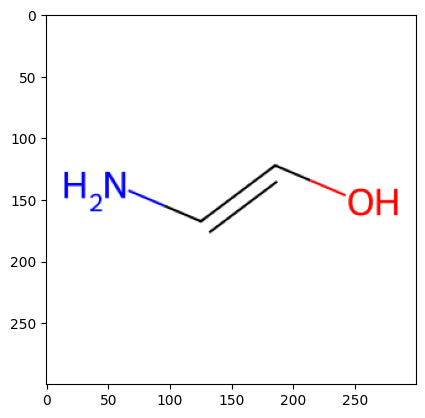

In [23]:
test_smiles = "C(O)=CN"
test_mol = Chem.MolFromSmiles(test_smiles)
Chem.MolToSmiles(test_mol) # we have to do this so we populate the _smilesAtomOutputOrder property
plt.imshow(Draw.MolToImage(test_mol))

print(test_smiles)
print()
atom_info(test_mol, verbose=True)
bond_info(test_mol, verbose=True)
(_, edge_attr), (_, fc_edge_attr) = connect_info(test_mol, verbose=True)
node_feature_matrix(test_mol, a2t, verbose=True )
map_rdkit_bond_types(edge_attr, verbose=True)
map_rdkit_bond_types(fc_edge_attr, verbose=True)

Next, we'll apply all these functions to each molecule in our Pandas dataframe.

In [24]:
def prepare_df(row):
        
    mol = row['mol']
    
    (edge_index, edge_attr), (fc_edge_index, y_fc_edge_attr)  = connect_info(mol)
    # y_boa is y labels for bag-of-atoms ->
    # a (vocab_size,) shape labels that shows the number of atoms for each atom 
    x, pos, y_boa = node_feature_matrix(mol, a2t) 
    edge_attr = map_rdkit_bond_types(edge_attr)
    y_fc_edge_attr = map_rdkit_bond_types(y_fc_edge_attr)
    # note that PyG will automatically increment fc_edge_index
    # as per the following doc:
    # https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Batch.html#torch_geometric.data.Batch
    data = Data(x=x,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y_boa=y_boa,
                fc_edge_index=fc_edge_index,
                y_fc_edge_attr=y_fc_edge_attr,
                pos=pos,
                graph_id = torch.tensor([row.name])) # to keep track of this data object and map to SMILES later
    data.validate(raise_on_error=True)
    return data

df["data"] = df.progress_apply(prepare_df, axis=1)

100%|██████████| 1000/1000 [00:03<00:00, 332.87it/s]


Note that we are not quite ready to pass this into any Graph convolutional network, because we only have the tokens. We will take care of that in the forward pass though. For now, we will use batching here.

## Training step

In [26]:
class DataFrameDataset(Dataset):
    """Wrapper class to use Pytorch DataLoader"""
    def __init__(self, df, colname="data"):
        self.data = df[colname].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
###################################################
# Hyperparameters
DEBUG = True 
embd = 16 # embedding size of a vocab indice
num_layers = 3    # number of GCN layers
lr = 0.002
betas = (0.9, 0.999)
eps = 1e-08
epochs = 2000
lambda_boa = 0.05
lambda_edge = 0.95
lambda_kl = 0
batch_size = 128
shuffle = False
###################################################

In [29]:
torch.manual_seed(42)

vocab_size = len(a2t)

dataset = DataFrameDataset(df, "data")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

Let's take a look at one of the batches to see which data is bundled:

In [32]:
data = next(iter(loader))
print(data)

DataBatch(x=[3054, 1], edge_index=[2, 6576], edge_attr=[6576], pos=[3054, 1], y_boa=[128, 8], fc_edge_index=[2, 72834], y_fc_edge_attr=[72834], graph_id=[128], batch=[3054], ptr=[129])


- `x` is the node (atom) features, and PyTorch Geometric has batched together 3054 of them.
- `edge_index` is the edge connectivity in COO format and there are 6576 edges (bonds) in the batched graph
- `edge_attr` is the edge (bond) features and the size matches `edge_index`
- `pos` is an attribute we defined which encodes the unique position for each node in the molecule
- `y_boa` is the target bag of atoms output where there are 8 possible atoms, and we have 128 different graphs (molecules)
- `fc_edge_index` is another target label which specifies all 72834 edges for a fully connected graph where every sub-graph connects to each other. This is used for the second stage of MoleGen (bond decoding)
- `y_fc_edge_attr` are the expected labels for each bond in the fully connected molecule
- `graph_id` is a tag which can associate each batched subgraph to a particular entry in the Pandas dataframe
- `batch` specifies which nodes belong to which subgraph in the `x` tensor
- `ptr` is similar to `batch` excepts it specifies the start position of each new graph


The model is defined below:

In [35]:
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import ResGatedGraphConv
from torch_geometric.utils import scatter
import torch
import torch.nn.functional as F

class AtomMLP(nn.Module):
    """Multi-layer perceptron (MLP) which predicts BOA for each graph
    
    Implementation of Eq. 9 in paper. This MLP takes in a graph level embedding 'z'
    and produces a BOA where we essentially get an integer distribution of the predicted atoms

    Args:
        embd       : embedding dimension for latent space
        vocab_size : number of unique atoms in training set
        max_atoms  : max number of total atoms in any molecule
    """
    def __init__(self, embd=16, vocab_size=8, max_atoms=100):
        
        super().__init__()   
        
        self.vocab_size = vocab_size
        self.max_atoms = max_atoms
        
        # note there isn't much information on the paper on this MLP but I am assuming we
        # use a nn.ReLU for the activation
        self.mlp = nn.Sequential(
            nn.Linear(embd, embd),
            nn.ReLU(),
            nn.Linear(embd, vocab_size*max_atoms),
        )
        
    def forward(self, z):
        """Forward pass of Atom MLP
        
        We compute an output vector of size (num_graphs, vocab_size, max_atoms) with
        the last dimension essentially representing a one-hot vector that has a dimension size
        up to the maximum number of atoms. We perform the MLP with a flattened last dimension
        (vocab_size*max_atoms) and then view it as a separate dimension for the loss calculation.
        
        Note that a small optimization here 
        is to not do the total number of atoms in the training set but simply the
        highest number of any particular atom instead.
        
        Args:
            z   : graph level embedding (num_graphs, embd)
            
        Returns:
            boa : graph level BOA (num_graphs, vocab_size, max_atoms)
        """
        boa = self.mlp(z)
        
        return boa.view(-1, self.vocab_size, self.max_atoms)


class BondMLP(nn.Module):
    """Multi-layer perceptron which predicts which bond for each edge
    
    Implementation of Eq. 11 in paper. This MLP takes in edge embeddings 'e'
    and produces an integer distribution of the predicted bond types

    Args:
        embd       : embedding dimension for latent space
        num_bonds  : number of unique atoms in training set
        num_bonds  : number of different types of bonds for classification
        
    """
    def __init__(self, embd=16, num_bonds=4):
        super().__init__()   
        
        self.num_bonds = num_bonds
        
        self.mlp = nn.Sequential(
            nn.Linear(embd, embd),
            nn.ReLU(),
            nn.Linear(embd, num_bonds),
        )
        
    def forward(self, e):
        """Forward pass of Bond MLP
        
        We compute an output vector of size (num_edges, num_bonds) with
        the last dimension representing a one-hot vector that has a dimension size
        up to the different types of bonds.
        
        Args:
            e   : edge embedding (num_edges, embd)
            
        Returns:
            bonds : graph level BOA (num_edges, num_bonds)
        """
        bonds = self.mlp(e)
        return bonds

        
class AtomGCNLayer(nn.Module):
    """Updates atom embeddings with Conv->BN->Relu->Residual

    Implementation of Eq. 4 in paper

    Args:
        embd       : embedding dimension for latent space    

    """
    def __init__(self, embd=16):
        super().__init__()

        self.gcn = ResGatedGraphConv(in_channels=embd, out_channels=embd, edge_dim=embd)
        self.bn = nn.BatchNorm1d(embd)
        self.relu = nn.ReLU()

    def forward(self, data):
        """Perform forward pass for atom GCN
        
        Args:
            data  : PyG Data() object (possibly batched) with the following attributes:
                x           : atom token, e.g. x[0] is the embedding vector for atom/node 0 (num_nodes, embd)
                edge_index  : bond connectivity, e.g. atom at edge_index[0,0] connects to edge_index[1, 0] (2, num_edges)
                edge_attr   : bond token, e.g. edge_attr[0] is the embedding vector for bond/edge 0 (num_edges, embd)
                
        Returns:
            h     :   Updated node embedding (num_nodes, embd)
            
        """ 
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.gcn(x, edge_index, edge_attr)
        h = self.bn(h)
        h = self.relu(h)
        h = x + h # residual pathway
        return h

class BondGCNLayer(nn.Module):
    """Updates bond embeddings with Linear->BN->Relu->Residual

    Implementation of Eq. 5 in paper
    
    Args:
        embd       : embedding dimension for latent space

    """

    def __init__(self, embd=16):
        super().__init__()
        self.v = nn.ModuleList([nn.Linear(embd,embd) for _ in range(3)])
        self.bn = nn.BatchNorm1d(embd)
        self.relu = nn.ReLU()

    def forward(self, data):
        """Perform forward pass for bond GCN
        
        Args:
            data  : PyG Data() object (possibly batched) with the following attributes:
                x           : atom token, e.g. x[0] is the embedding vector for atom/node 0 (num_nodes, embd)
                edge_index  : bond connectivity, e.g. atom at edge_index[0,0] connects to edge_index[1, 0] (2, num_edges)
                edge_attr   : bond token, e.g. edge_attr[0] is the embedding vector for bond/edge 0 (num_edges, embd)
                
        Returns:
            e     :   Updated edge embedding (num_edges, embd)
            
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h_src = x[edge_index[0]] # oh... apparently we get this for free?
        h_dest = x[edge_index[1]] # apparently pytorch geometric already handles large batch

        e = self.v[0](edge_attr) + self.v[1](h_src) + self.v[2](h_dest)

        e = self.bn(e)
        e = self.relu(e)

        e = edge_attr + e # residual pathway
        return e

class MoleGen(nn.Module):
    """Main model for VAE molecular generation
    
    This model is an implementation of the paper:
    A Two-Step Graph Convolutional Decoder for Molecule Generation
    by Bresson et Laurent (2019). A molecule graph is first encoded 
    into a latent representation 'z', which is used to produce a 
    'Bag of Atoms' (BOA). This BOA tells us how many of each atom
    we have in the predicted molecule, ignoring connectivity. 
    The second stage takes 'z' and the original input formula and
    decodes the edge feature connectivity from a fully connected network.
    
    Args:
        vocab_size : number of unique atoms in training set
        embd       : embedding dimension for latent space
        num_layers : number of GNN layers (message passing/k-hop distance)
        max_atoms  : max number of total atoms in any molecule
        num_bonds  : number of different types of bonds for classification
    """
    def __init__(self, vocab_size=8, embd=16, num_layers=4, max_atoms=100, num_bonds=4):
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embd = embd
        self.num_layers = num_layers
        self.max_atoms = max_atoms

        self.bond_embeddings = nn.Embedding(vocab_size, embd) 
        self.atom_encoder = nn.ModuleList([AtomGCNLayer(embd) for _ in range(num_layers)])
        self.bond_encoder = nn.ModuleList([BondGCNLayer(embd) for _ in range(num_layers)])
        self.atom_decoder = nn.ModuleList([AtomGCNLayer(embd) for _ in range(num_layers)])
        self.bond_decoder = nn.ModuleList([BondGCNLayer(embd) for _ in range(num_layers)])
        
        self.N = torch.distributions.Normal(0, 1)

        self.linear = nn.ModuleDict(dict(
            atom_embedding=nn.Linear(max_atoms + vocab_size, embd),
            a_mu=nn.Linear(embd, embd),
            b_mu=nn.Linear(embd, embd),
            c_mu=nn.Linear(embd, embd),
            d_mu=nn.Linear(embd, embd),
            a_sigma=nn.Linear(embd, embd),
            b_sigma=nn.Linear(embd, embd),
            c_sigma=nn.Linear(embd, embd),
            d_sigma=nn.Linear(embd, embd),
            u=nn.Linear(embd, embd)
        ))

        self.sigmoid = nn.Sigmoid()
        
        self.atom_mlp = AtomMLP(embd, vocab_size, max_atoms)
        self.bond_mlp = BondMLP(embd, num_bonds)
        
    def forward(self, input_data):
        """Forward pass for MoleGen
        
        First we look up the atom and bond embeddings, and then apply GCN layers iteratively.
        Afterwards we reduce the node and edge embeddings into a single graph latent vector 'z'.
        We apply MLP to 'z' to produce a BOA. Then we use the original 'x' tokens and the 'z' vector
        to produce an edge probability matrix, which we again apply an MLP to to get 's' which is
        the predicted bond tokens for each edge of a fully connected network.
        
        Args:
            input_data  : PyG Data() object (possibly batched) with the following attributes:
                x           : atom token, e.g. x[0] is the integer token for atom/node 0 (num_nodes, 1)
                edge_index  : bond connectivity, e.g. atom at edge_index[0,0] connects to edge_index[1, 0] (2, num_edges)
                edge_attr   : bond token, e.g. edge_attr[0] is the integer token for bond/edge 0 (num_edges, )
                
        Returns:
            boa     :   Bag of Atoms prediction (num_graphs, vocab_size, max_atoms)
            z       :   Per graph latent representation (num_graphs, embd)
            s       :   Edge probability matrix (num_fc_edges, num_bonds)
        """


        ######################################################################################
        # Encoding step
        ######################################################################################
        
        # Break symmetry and add positional embeddings to atom embeddings
        one_hot_positions = F.one_hot(input_data.pos.view(-1).long(), num_classes=self.max_atoms) # view avoids extra dimension added
        one_hot_atom_tokens = F.one_hot(input_data.x.view(-1).long(), num_classes=self.vocab_size)
        one_hot_concat = torch.cat((one_hot_positions, one_hot_atom_tokens), 1).to(dtype=torch.float32)
        atom_embedding = self.linear['atom_embedding'](one_hot_concat)
        
        # Get bond embeddings
        bond_embedding = self.bond_embeddings(input_data.edge_attr)

        # Apply GCN layers iteratively (encoding)
        h = atom_embedding
        e = bond_embedding
        for i in range(self.num_layers):
            data = Data(x=h, edge_index=input_data.edge_index, edge_attr=e)
            h = self.atom_encoder[i](data)
            e = self.bond_encoder[i](data)

        # Extract source and destination atom features 
        h_src = h[input_data.edge_index[0]]
        h_dest = h[input_data.edge_index[1]]

        # Apply linear and activation before reduction step
        # mu = (self.sigmoid(self.linear['a_mu'](e) + self.linear['b_mu'](h_src) + self.linear['c_mu'](h_dest)))*self.linear['d_mu'](e)
        # sigma = (self.sigmoid(self.linear['a_sigma'](e) + self.linear['b_sigma'](h_src) + self.linear['c_sigma'](h_dest)))*self.linear['d_sigma'](e)
        
        z = (self.sigmoid(self.linear['a_sigma'](e) + self.linear['b_sigma'](h_src) + self.linear['c_sigma'](h_dest)))*self.linear['d_sigma'](e)
        
        # the .batch attribute only maps to nodes
        # to get a mapping to the edge -> graph we simply index
        # into the batch to get the indexes of which edge corresponds to which graph 
        batch_edge = input_data.batch[input_data.edge_index[0]] # (num_edges, )
        
        # now batch_edge will ressemble input_data.batch but for edges instead of nodes
        # apply scatter operation to get a per graph output
        # mu = scatter(mu, batch_edge, dim=0, reduce='sum') # (num_graphs, embd)
        # sigma = scatter(sigma, batch_edge, dim=0, reduce='sum') # (num_graphs, embd)
        
        # z = mu + sigma*self.N.sample(mu.shape)
        z = scatter(z, batch_edge, dim=0, reduce='sum')
        
        # kl = -((1 + torch.log(sigma**2) - (mu**2) - (sigma**2)).sum()) # from https://arxiv.org/pdf/1312.6114
        kl = torch.tensor([0])
        boa = self.atom_mlp(z) # (num_graphs, vocab_size, max_atoms)


        ######################################################################################
        # Decoding step
        ######################################################################################

        # in the bond generation step, each edge gets the same initial feature vector
        fc_bond_embedding = self.linear['u'](z) # (num_graphs, embd) 
        
        # same trick as before where we convert node mappings to edge mappings
        fc_batch_edge = input_data.batch[input_data.fc_edge_index[0]]
        
        # we index into our bond embeddings to get the bond embeddings
        # for each edge per graph, since fc_bond_embedding is batched
        fc_edge_attr = fc_bond_embedding[fc_batch_edge] # (num_fc_edges, embd)
        
        # re-use original atom embedding since the fc graph has the same nodes just with different bonds
        fc_atom_embedding = atom_embedding # (num_atoms, embd)
        
        # Apply GCN layers iteratively (decoding)
        h = fc_atom_embedding
        e = fc_edge_attr
        for i in range(self.num_layers):
            data = Data(x=h, edge_index=input_data.fc_edge_index, edge_attr=e)
            h = self.atom_decoder[i](data)
            e = self.bond_decoder[i](data)  
        
        # now take each edge and apply MLP to predict bond type for each
        s = self.bond_mlp(e)
        
        return boa, z, s, kl



In [39]:
model = MoleGen(vocab_size=vocab_size, num_layers=num_layers, embd=embd, max_atoms=max_atoms)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps)
loss_fn = torch.nn.CrossEntropyLoss()

print(model)

MoleGen(
  (bond_embeddings): Embedding(8, 16)
  (atom_encoder): ModuleList(
    (0-2): 3 x AtomGCNLayer(
      (gcn): ResGatedGraphConv(16, 16)
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (bond_encoder): ModuleList(
    (0-2): 3 x BondGCNLayer(
      (v): ModuleList(
        (0-2): 3 x Linear(in_features=16, out_features=16, bias=True)
      )
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (atom_decoder): ModuleList(
    (0-2): 3 x AtomGCNLayer(
      (gcn): ResGatedGraphConv(16, 16)
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (bond_decoder): ModuleList(
    (0-2): 3 x BondGCNLayer(
      (v): ModuleList(
        (0-2): 3 x Linear(in_features=16, out_features=16, bias=True)
      )
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, tr

We can optionally load a checkpoint if it exists

In [ ]:
torch.serialization.add_safe_globals([float])
checkpoint = torch.load("molegen.ckpt", weights_only=True)
loss = checkpoint['loss']
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

We define a useful debug function that is output at each batch

In [40]:
def debug_fn(batch, boa, z, s, MAX_SMILES_STRING=50):
    
    smiles = df['canonical_smiles'].iloc[batch.graph_id[0].item()]
    
    print(f"({idx:<2}) {smiles[:MAX_SMILES_STRING]:<{MAX_SMILES_STRING}}{'...' if len(smiles) > MAX_SMILES_STRING else '   '} | ", end="")
    
    boa_actual = batch.y_boa[0]
    boa_pred = torch.argmax(boa[0], dim=-1)
    
    for token, (count, pred_count) in enumerate(zip(boa_actual, boa_pred)):
        print(f"{t2a[token]}({count}, {pred_count}) | ", end="")
    
    
    # select only edges that correspond to first graph 
    edge = batch.batch[batch.fc_edge_index[0]] # (num_edges, )
    edge = torch.arange((edge[edge == 0]).shape[0]) # (num_edges_graph0, )
    edge_pred = s[edge] # (num_edges_graph0, C)
    edge_pred = torch.argmax(edge_pred, dim=-1) # (num_edges_graph0, )
    
    src_atoms = batch.fc_edge_index[0, edge] # (num_edges_graph0, )
    dest_atoms = batch.fc_edge_index[1, edge] # (num_edges_graph0, )
    src_atom_feats = batch.x[src_atoms].squeeze(-1) # (num_nodes_graph0, )
    dest_atom_feats = batch.x[dest_atoms].squeeze(-1) # (num_nodes_graph0, )

    # only show the edges that are not zero because we would have too many otherwise
    correct_edges = 0
    num_edges = 0
    for num, (src, dest, actual, predicted) in enumerate(zip(src_atom_feats, dest_atom_feats, batch.y_fc_edge_attr, edge_pred)):
        if actual != 0:
            num_edges += 1
            if actual == predicted:
                correct_edges += 1
                
    print(f"edges {correct_edges}/{num_edges}")

In [41]:
model.train()
MAX_SMILES_STRING = 50
for epoch in range(epochs):
    loss = dict()
    avg_loss = defaultdict(float)

    for idx, batch in enumerate(loader):
        boa, z, s, kl = model(batch)
        
        if DEBUG:   
            debug_fn(batch, boa, z, s, MAX_SMILES_STRING) 
                    
        optimizer.zero_grad()
        
        # we have to permute because loss function expects (N, C, d1, d2, dK)
        # and we have a K-dimensional loss here
        loss['boa'] = loss_fn(torch.permute(boa, (0, 2, 1)), batch.y_boa.long())
        
        # we don't need to change input because s is already with shape (B, C) and
        # y_fc_edge_attr has shape (B,) with each value between 0 and C
        loss['edge'] = loss_fn(s, batch.y_fc_edge_attr.long())
        
        loss['kl'] = kl
        
        loss['total'] = lambda_boa*loss['boa'] + lambda_edge*loss['edge'] + lambda_kl*loss['kl']
        loss['total'].backward()
        
        # TODO: add torch inference mode wrapper here?
        avg_loss['total'] += loss['total'].item()
        avg_loss['boa'] += loss['boa'].item()
        avg_loss['edge'] += loss['edge'].item()
        avg_loss['kl'] += loss['kl'].item()
        
        optimizer.step()

    print()
    print(f"Epoch {epoch} ------ average losses ------- | ", end="")
    for name,value in avg_loss.items():
        print(f"{name}: {value/len(loader):.5f} | ", end="")
    print()
    print()



(0 ) CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1               | C(20, 5) | O(2, 19) | N(1, 17) | F(1, 26) | S(0, 25) | Cl(0, 7) | Br(0, 33) | I(0, 29) | edges 42/52
(1 ) CSc1ccc(/C=c2\sc3ncnn3c2=O)cc1                        | C(12, 5) | O(1, 12) | N(3, 17) | F(0, 26) | S(2, 23) | Cl(0, 7) | Br(0, 26) | I(0, 29) | edges 4/40
(2 ) COc1cc(OC)cc([C@H]2CC[NH+](CCC(F)(F)F)C2)c1           | C(15, 5) | O(2, 19) | N(1, 24) | F(3, 26) | S(0, 0) | Cl(0, 27) | Br(0, 33) | I(0, 5) | edges 0/44
(3 ) C[C@H]([NH2+]C1C[C@H](C)O[C@@H](C)C1)c1c[nH]c2cc(F... | C(17, 5) | O(1, 19) | N(2, 24) | F(1, 7) | S(0, 18) | Cl(0, 23) | Br(0, 33) | I(0, 5) | edges 0/46
(4 ) CS[C@@H]1CC[C@H](NC(=O)CCC(=O)c2ccc(C)s2)C1           | C(15, 5) | O(2, 7) | N(1, 24) | F(0, 6) | S(2, 0) | Cl(0, 27) | Br(0, 26) | I(0, 29) | edges 0/42
(5 ) CCCn1/c(=N/C(=O)[C@@H](CCSC)NC(N)=O)[nH]c2ccccc21     | C(16, 5) | O(2, 7) | N(5, 24) | F(0, 6) | S(1, 23) | Cl(0, 27) | Br(0, 26) | I(0, 29) | edges 0/50
(6 ) COc1ccc(F)cc1NC(=O)N1CCO[C@H](c2c

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x708df4891fc0>>
Traceback (most recent call last):
  File "/home/justin/files/projects/mole_gen/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


edges 0/58

Epoch 18 ------ average losses ------- | total: 0.35968 | boa: 1.03027 | edge: 0.32439 | kl: 0.00000 | 

(0 ) CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1               | C(20, 18) | O(2, 2) | N(1, 3) | F(1, 0) | S(0, 0) | Cl(0, 0) | Br(0, 0) | I(0, 0) | edges 0/52
(1 ) CSc1ccc(/C=c2\sc3ncnn3c2=O)cc1                        | C(12, 18) | O(1, 2) | N(3, 3) | F(0, 0) | S(2, 0) | Cl(0, 0) | Br(0, 0) | I(0, 0) | edges 0/40
(2 ) COc1cc(OC)cc([C@H]2CC[NH+](CCC(F)(F)F)C2)c1           | C(15, 16) | O(2, 2) | N(1, 4) | F(3, 0) | S(0, 0) | Cl(0, 0) | Br(0, 0) | I(0, 0) | edges 0/44
(3 ) C[C@H]([NH2+]C1C[C@H](C)O[C@@H](C)C1)c1c[nH]c2cc(F... | C(17, 16) | O(1, 1) | N(2, 3) | F(1, 0) | S(0, 0) | Cl(0, 0) | Br(0, 0) | I(0, 0) | edges 0/46
(4 ) CS[C@@H]1CC[C@H](NC(=O)CCC(=O)c2ccc(C)s2)C1           | C(15, 18) | O(2, 2) | N(1, 2) | F(0, 0) | S(2, 0) | Cl(0, 0) | Br(0, 0) | I(0, 0) | edges 0/42
(5 ) CCCn1/c(=N/C(=O)[C@@H](CCSC)NC(N)=O)[nH]c2ccccc21     | C(16, 18) | O(2, 3) | N(5, 3) | F(0, 0) | 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x708df4891fc0>>
Traceback (most recent call last):
  File "/home/justin/files/projects/mole_gen/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


(2 ) COc1cc(OC)cc([C@H]2CC[NH+](CCC(F)(F)F)C2)c1           | C(15, 16) | O(2, 2) | N(1, 2) | F(3, 0) | S(0, 0) | Cl(0, 0) | Br(0, 0) | I(0, 0) | edges 0/44


KeyboardInterrupt: 

We can optionally save our current checkpoint

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'avg_loss': avg_loss
}, "molegen.ckpt")

## Visualizing latent space

(128, 2)


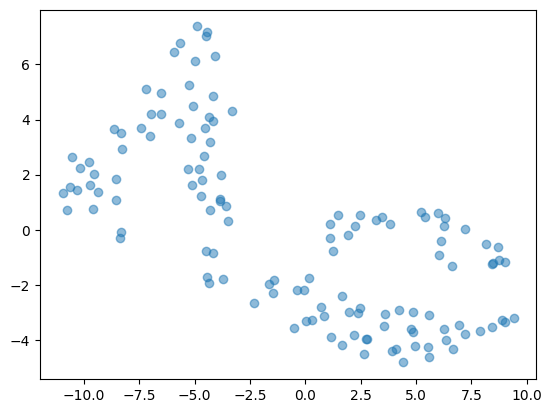

In [ ]:
model.eval()
tsne = TSNE(random_state=10) 
tsne_repr = tsne.fit_transform(z.cpu().detach().numpy())
print(tsne_repr.shape)
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], alpha=0.5)